In [ ]:
!pip install rasterio
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 890 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import rasterio
import tifffile as tiff
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

In [ ]:
# Example image
# /content/drive/MyDrive/dset-s2/tra_scene/S2B_L2A_20181226_N0211_R102_6Bands_S2.tif
img_name = 'S2B_L2A_20181226_N0211_R102'
img_path = f"/content/drive/MyDrive/dset-s2/tra_scene/{img_name}_6Bands_S1.tif"
mask_path = f"/content/drive/MyDrive/dset-s2/tra_truth/{img_name}_S1_Truth.tif"


with rasterio.open(img_path) as f:
  img = f.read()

with rasterio.open(mask_path) as f:
  mask = f.read()


print(f'image shape: {img.shape} | mask shape: {mask.shape}')

image shape: (6, 1197, 1229) | mask shape: (1, 1197, 1229)


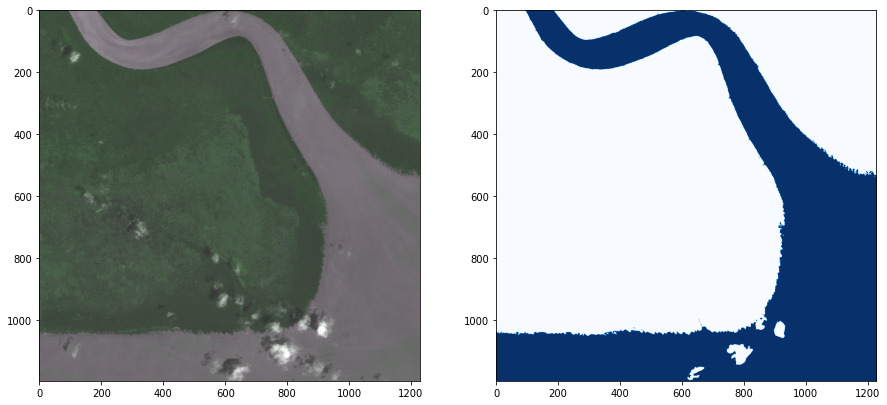

In [ ]:
# visualizing original image and mask

def normalize(img):
  """ normalize pixel values between 0 and 1"""
  return (img - img.min()) / (img.max() - img.min())
  


red, green, blue = img[0], img[1], img[2]
rgb = np.dstack((blue, green, blue))

brightness = 0.2
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(normalize(rgb) + brightness)
axs[1].imshow(mask.squeeze(), cmap='Blues')

In [ ]:
# patchify
step = 128
patches = patchify(image=img, patch_size=(6, 128, 128), step=step)
patches.shape

(1, 9, 9, 6, 128, 128)

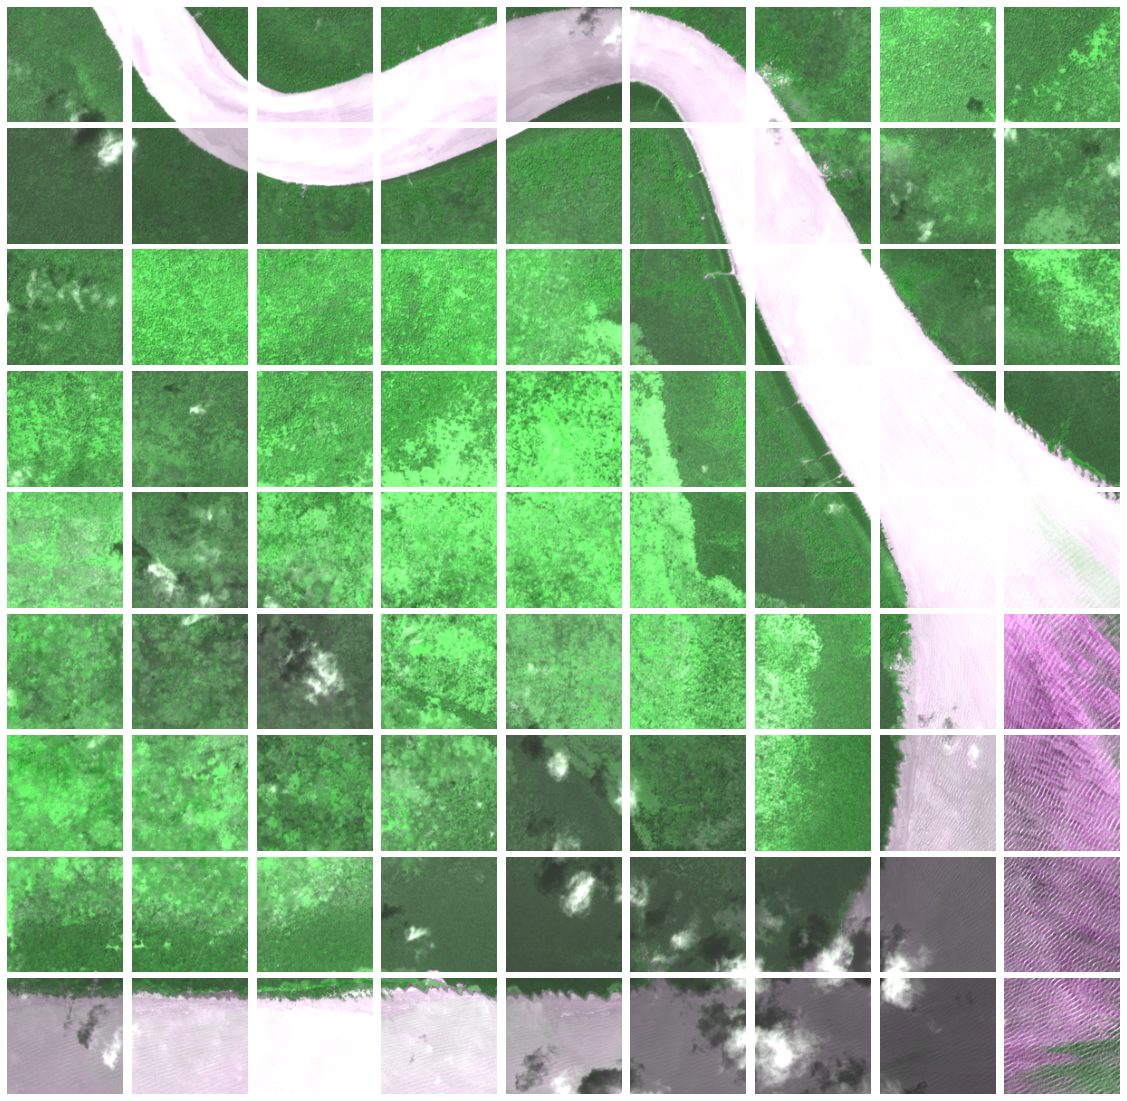

In [ ]:
# visualize patches
brightness = 0.2
fig, axs = plt.subplots(patches.shape[1], patches.shape[2], figsize=(20, 20))

for i in range(patches.shape[1]):
  for j in range(patches.shape[2]):
    patch = patches[0, i, j]

    red, green, blue = patch[0], patch[1], patch[2]
    rgb = np.dstack((blue, green, blue))
   
    axs[i, j].imshow(normalize(rgb) + brightness)
    axs[i, j].set_axis_off()

fig.subplots_adjust(wspace=0.05, hspace=0.05) 

### Patches for training


In [ ]:
patch_size = 256
root_dir = "/content/drive/MyDrive/dset-s2/"
train = {'tra_scene':[], 'tra_truth':[]}

for key in train:
  train_dir = os.path.join(root_dir, key)

  for img_path in sorted(glob.glob(os.path.join(train_dir,"*.tif"))):
    img = tiff.imread(img_path)
    
    if key == 'tra_scene':
      img = np.moveaxis(img, 0, -1)
      patch_img = patchify(img, (patch_size, patch_size, img.shape[-1]), step=patch_size)
      input_img = np.reshape(patch_img, (-1, patch_img.shape[3], patch_img.shape[4], patch_img.shape[5]))
    else:
      patch_img = patchify(img, (patch_size, patch_size), step=patch_size)
      input_img = np.reshape(patch_img, (-1, patch_img.shape[2], patch_img.shape[3]))


    for image in input_img:
      train[key].append(image)


for key in train:
  train[key] = np.array(train[key])

In [ ]:
print(train['tra_scene'].shape)
print(train['tra_truth'].shape)

(771, 256, 256, 6)
(771, 256, 256)


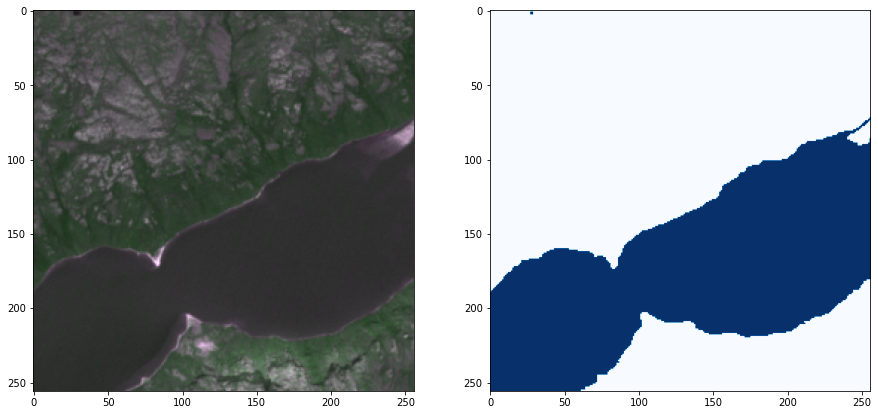

In [ ]:
# Sanity check (pick any random patch and make sure both image and mask align)
idx = np.random.randint(train['tra_truth'].shape[0])

img = train['tra_scene'][idx]
mask = train['tra_truth'][idx]

red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]
rgb = np.dstack((blue, green, blue))

brightness = 0.1
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(normalize(rgb) + brightness)
axs[1].imshow(mask.squeeze(), cmap='Blues')